In [1]:
from glob import glob

from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from keras import layers
from keras.layers import Input, Conv2D, concatenate
from keras.models import Model
from keras.regularizers import l1_l2

import os
import numpy as np
import cv2
from PIL import Image

pgm_orgpath = ('C:/Users/Boyce/OneDrive/Documents/ICA/ICA/Database_134_Angiograms')
org_path = ('C:/Users/Boyce/OneDrive/Documents/ICA/ICA/Database_134_Angiograms/1.pgm')



In [2]:
import torch

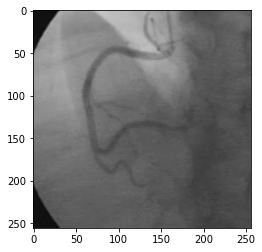

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 1)  25          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 1)  9           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 256, 256, 16) 400         conv2d_7[0][0]                   
____________________________________________________________________________________________

In [4]:
def readpgm(name, img_size=None, use_rgb=False):
    with open(name) as f:
        lines = f.readlines()

    # Ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    # Makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2' 

    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    data =(np.array(data[3:]),(data[1],data[0]),data[2])
    img = np.array(np.reshape(data[0],data[1]),dtype = np.uint8)
    if img_size is not None:        
        img = Image.fromarray(img)
        if use_rgb:
            img = img.convert('RGB')
        img = img.resize(img_size)
        img = np.array(img)
        
    return img

sample_or = readpgm(org_path, (256,256))
plt.imshow(sample_or,cmap='gray', vmin=0, vmax=255)
plt.show()
sample_or.shape


def APN():
    inputs = Input(shape=(256,256,1))
    activation_func = None
    X1 = Conv2D(1, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func,
                use_bias=False, data_format="channels_last")(inputs)
#(filters, kernal_size)
    X2 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func,
                use_bias=False, data_format="channels_last")(X1)
    X3 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func,
                use_bias=False, data_format="channels_last")(X2)
    X4 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func,
                use_bias=False, data_format="channels_last")(X3)
    X5 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func,
                use_bias=False, data_format="channels_last")(X4)
    X6 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation='tanh',
                use_bias=False, data_format="channels_last")(X5)
    X7 = concatenate([X6, X6, X6], axis=3)

    model = Model(inputs=inputs, outputs=X7)
    return model

model = APN()
model.summary()
keras_result = model(np.expand_dims(sample_or,-1))




In [ ]:
model.fit()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from matplotlib import pyplot as plt
from functools import reduce
from operator import __add__

class Conv2dSamePadding(nn.Conv2d):
    def __init__(self,*args,**kwargs):
        super(Conv2dSamePadding, self).__init__(*args, **kwargs)
        self.zero_pad_2d = nn.ZeroPad2d(reduce(__add__,
            [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in self.kernel_size[::-1]]))

    def forward(self, input):
        return  self._conv_forward(self.zero_pad_2d(input), self.weight, self.bias)

class TorchAPN(nn.Module):
    def __init__(self):
        super(TorchAPN , self).__init__()
        self.conv_1 = Conv2dSamePadding(1,1,5, bias=False)       
        self.conv_2 = Conv2dSamePadding(1,1,3, bias=False)
        self.conv_3 = Conv2dSamePadding(1,16,5, bias=False)
        self.conv_4 = Conv2dSamePadding(16,16,5, bias=False)
        self.conv_5 = Conv2dSamePadding(16,16,5, bias=False)       
        self.conv_6 = nn.Sequential(Conv2dSamePadding(16,1,3, bias=False), nn.Tanh())
    def forward(self, x):
        x1 = self.conv_1(x)
        x2 = self.conv_2(x1)
        x3 = self.conv_3(x2)
        x4 = self.conv_4(x3)
        x5 = self.conv_5(x4)
        x6 = self.conv_6(x5)
        x7 = torch.cat((x6, x6, x6), 0)
        
        return x7

img = TF.to_tensor(sample_or)
img = img.unsqueeze(0)

model2= TorchAPN()
model2
torch_result=model2(img)